# Logistic curve fitting to predict covid-19 cases curves v1.0


**Source data git repo:** [CSSEGISandData/COVID-19 repo](https://github.com/CSSEGISandData/COVID-19)

**Source model information page:** [medium covid-19-growth-modeling](https://medium.com/@andrejusb/covid-19-growth-modeling-and-forecasting-with-prophet-2ff5ebd00c01)

**Source model information git repo:** [katanaml/covid19 repo](https://github.com/katanaml/covid19)

**Source model information Web UI:** [katanaml covid19 app](https://app.katanaml.io/covid19/)

**Results dashboard:** [dashboard](https://esri-colombia.maps.arcgis.com/apps/opsdashboard/index.html#/4f8a0e62196c4c32b592e78f825f6cd6)

#### Run this cell to connect to your GIS and get started:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
# from sklearn import linear_model
from scipy.special import expit
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline
import math
import datetime

one_day = datetime.timedelta(days=1)
import extract
from config import ESRI_USER, ESRI_PASSWORD
from utils import exponential_regression, logistic_regression, hill_regression, graph_lyh

In [2]:
from arcgis.gis import GIS
gis = GIS("https://sersig-esri-co.maps.arcgis.com/home/", ESRI_USER, ESRI_PASSWORD)
# from arcgis.features import FeatureLayerCollection

## Extract and clean

#### Import repository data 

In [3]:
d=extract.pulldataDict()
df0=d['Dataframe']
sites=d['sites']

### Example y tests 

In [4]:
#x,y equals to days and accumulated and fit the curve of logistic function
dfc=df0[df0['site']=='Colombia']
dfc=dfc[dfc.accumulated!=0]
dfc['days']=np.arange(len(dfc.index))+1
x,y=np.array(dfc.days),np.array(dfc.accumulated)

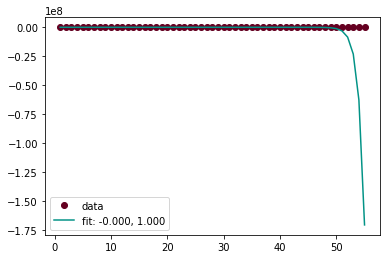

In [5]:
exponential_regression(x, y)

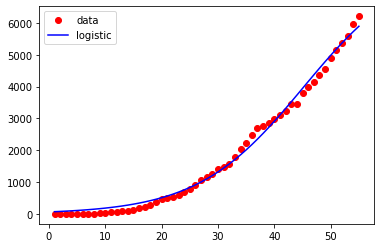

In [6]:
logistic_regression(x, y)

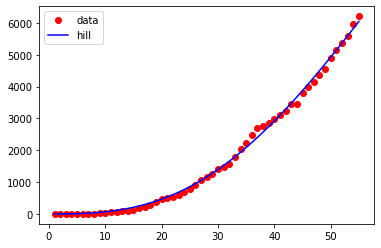

In [7]:
hill_regression(x, y)

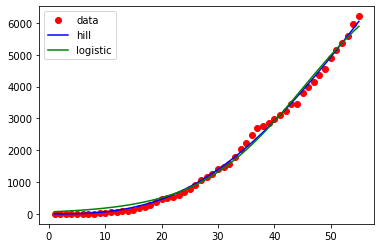

In [8]:
graph_lyh(x,y)

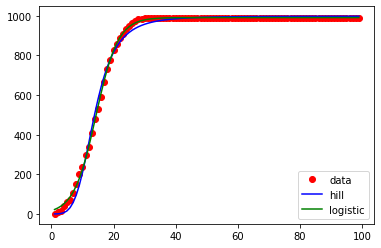

In [10]:
dfc=df0[df0['site']=='China-Anhui']
dfc=dfc[dfc.accumulated!=0]
dfc['days']=np.arange(len(dfc.index))+1
xc,yc=np.array(dfc.days),np.array(dfc.accumulated)
graph(xc, yc)

In [51]:
def create_dataframe_with_forecast(df0,site):
    df_data=df0[df0['site']==site]
    df_data=df_data[df_data.accumulated!=0]
    df_data['days']=np.arange(len(df_data.index))+1
    df_data=df_data[['site','date','accumulated','days']]
    bounds = (0, [100000., 1000., 1000000000.])
    p0 = np.random.exponential(size=3)
    step=0
    x,y=np.array(df_data.days),np.array(df_data.accumulated) 
    while step<2:          
        popt,cov = curve_fit(func_logistic, x, y, bounds=bounds, p0=p0, maxfev=1000000)
        y_predict=func_logistic(x,*popt)
        r2=r2_score(y, y_predict)
        if r2<0.7:
            step+=1
        else:
            break
    df_forecast=pd.DataFrame()
    for i in np.arange(1,200):
        Day=df_data['days'].min()+i
        Date=df_data['date'].min()+(one_day*i)
        if Date <= datetime.datetime(2020, 5, 30):
            clean_negatives=lambda a: math.floor(func_logistic(a,*popt)) if math.floor(func_logistic(a,*popt))>0 else 0
            DayCases=clean_negatives(Day)
            day_df=pd.DataFrame([[site,
                                    Date,
                                    DayCases,
                                    Day]],columns=list(df_data))
            df_forecast=pd.concat([df_forecast,day_df])
        else:
            break
    popt_h,cov_h = curve_fit(func_hill, x, y, bounds=bounds, p0=p0, maxfev=1000000)
    df_forecast_h=pd.DataFrame()
    for i in np.arange(1,200):
        Day=df_data['days'].min()+i
        Date=df_data['date'].min()+(one_day*i)
        if Date <= datetime.datetime(2020, 5, 30):
#             clean_negatives=lambda x: math.floor(func_hill(x,*popt)) if math.floor(func_logistic(x,*popt))>0 else 0
            DayCases=math.floor(func_hill(Day,*popt_h))
            day_df_h=pd.DataFrame([[site,
                                    Date,
                                    DayCases,
                                    Day]],columns=list(df_data))
            df_forecast_h=pd.concat([df_forecast_h,day_df_h])
        else:
            break
    df_data['type']='data'
    df_forecast['type']='forecast'
#     df_forecast_h['type']='hill'
    df_data_forecast=pd.concat([df_data,df_forecast])
#     df_data_forecast=pd.concat([df_data_forecast,df_forecast_h])
    if y[-1]<=y[-2]:
        df_data_forecast['growth']='Estabilizado'
    else:
        df_data_forecast['growth']='Incrementando'
    
#     df_data_forecast['R2score']=r2
    print(site+'==> processed')# with r2:'+str(r2)+' in '+str(step)+' step')
    return df_data_forecast#,r2
def createFinal(df0,sites):
    Finaldf3=pd.DataFrame()
    scores={}
    for s in sites:
        dfi=create_dataframe_with_forecast(df0,s)
#         step=0
#         if r2 <0.7 or step==3:
#             dfi,r2=create_dataframe_with_forecast(df0,s)
#         scores[s]=r2
        Finaldf3=pd.concat([Finaldf3, dfi])
    Final3=Finaldf3.reset_index().drop(columns='index')
    fivehours=datetime.timedelta(hours=5)
    Final3['date']=Final3['date']+fivehours
    return Final3#, scores
def updateFeature(df0,sites):
    Final3=createFinal(df0,sites)
    CSVout3='forecast_{}.csv'.format(str(datetime.date.today()))
    Final3.to_csv(CSVout3)
    # Title: COVID-19_FORECAST | Type: Feature Service | Owner: rmartin_esri_colombia
    item_forecast = gis.content.get("e8308000b40d4ca2960d958d7ca977d0")
    collection = FeatureLayerCollection.fromitem(item_forecast)
    update_dict0 = {"capabilities": "Create,Delete,Query,Update,Editing"}
    collection.manager.update_definition(update_dict0)
    collection.manager.overwrite(CSVout3)
    update_dict1 = {"capabilities": "Query"}
    collection.manager.update_definition(update_dict1)
updateFeature(df0,sites)

Colombia==> processed


array(['data', 'logistic', 'hill'], dtype=object)

In [52]:
Final3=createFinal(df0,sites)

Afghanistan==> processed
Albania==> processed
Algeria==> processed
Andorra==> processed
Angola==> processed
Antigua and Barbuda==> processed
Argentina==> processed
Armenia==> processed
Australia-Australian Capital Territory==> processed
Australia-New South Wales==> processed
Australia-Northern Territory==> processed
Australia-Queensland==> processed
Australia-South Australia==> processed
Australia-Tasmania==> processed
Australia-Victoria==> processed
Australia-Western Australia==> processed
Austria==> processed
Azerbaijan==> processed
Bahamas==> processed
Bahrain==> processed
Bangladesh==> processed
Barbados==> processed
Belarus==> processed
Belgium==> processed
Benin==> processed
Bhutan==> processed
Bolivia==> processed
Bosnia and Herzegovina==> processed
Brazil==> processed
Brunei==> processed
Bulgaria==> processed
Burkina Faso==> processed
Cabo Verde==> processed
Cambodia==> processed
Cameroon==> processed
Canada-Alberta==> processed
Canada-British Columbia==> processed
Canada-Grand

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Poland==> processed
Portugal==> processed
Qatar==> processed
Romania==> processed
Russia==> processed
Rwanda==> processed
Saint Lucia==> processed
Saint Vincent and the Grenadines==> processed
San Marino==> processed
Saudi Arabia==> processed
Senegal==> processed
Serbia==> processed
Seychelles==> processed
Singapore==> processed
Slovakia==> processed
Slovenia==> processed
Somalia==> processed
South Africa==> processed
Spain==> processed
Sri Lanka==> processed
Sudan==> processed
Suriname==> processed
Sweden==> processed
Switzerland==> processed
Taiwan*==> processed
Tanzania==> processed
Thailand==> processed
Togo==> processed
Trinidad and Tobago==> processed
Tunisia==> processed
Turkey==> processed
Uganda==> processed
Ukraine==> processed
United Arab Emirates==> processed
United Kingdom-Bermuda==> processed
United Kingdom-Cayman Islands==> processed
United Kingdom-Channel Islands==> processed
United Kingdom-Gibraltar==> processed
United Kingdom-Isle of Man==> processed
United Kingdom-Mo

In [25]:
Final3.query("R2score<0.7")['site'].unique()

array(['Cabo Verde', 'Netherlands-Bonaire, Sint Eustatius and Saba', 'Yemen'], dtype=object)

In [31]:
Final3.query("site=='Cabo Verde'")

,site,date,accumulated,days,type,growth,R2score
4412,Cabo Verde,2020-03-20 05:00:00,1,1,data,Incrementando,0.533344
4413,Cabo Verde,2020-03-21 05:00:00,3,2,data,Incrementando,0.533344
4414,Cabo Verde,2020-03-22 05:00:00,3,3,data,Incrementando,0.533344
4415,Cabo Verde,2020-03-23 05:00:00,3,4,data,Incrementando,0.533344
4416,Cabo Verde,2020-03-24 05:00:00,3,5,data,Incrementando,0.533344
...,...,...,...,...,...,...,...
4505,Cabo Verde,2020-05-26 05:00:00,434,68,forecast,Incrementando,0.533344
4506,Cabo Verde,2020-05-27 05:00:00,434,69,forecast,Incrementando,0.533344
4507,Cabo Verde,2020-05-28 05:00:00,434,70,forecast,Incrementando,0.533344
4508,Cabo Verde,2020-05-29 05:00:00,434,71,forecast,Incrementando,0.533344


In [29]:
Final3.query("R2score<0.7").drop_duplicates(subset='site')

,site,date,accumulated,days,type,growth,R2score
4412,Cabo Verde,2020-03-20 05:00:00,1,1,data,Incrementando,0.533344
35614,"Netherlands-Bonaire, Sint Eustatius and Saba",2020-04-02 05:00:00,2,1,data,Estabilizado,0.662741
36088,Yemen,2020-04-10 05:00:00,1,1,data,Estabilizado,0.000000


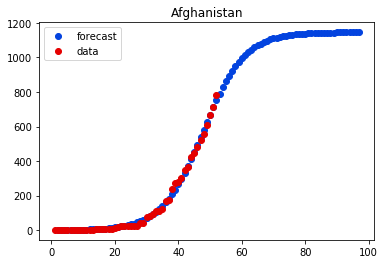

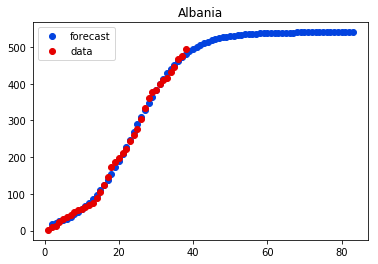

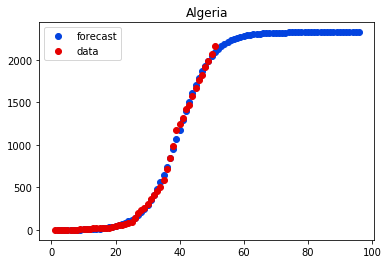

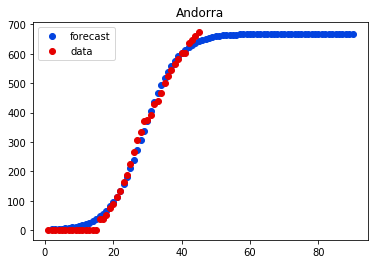

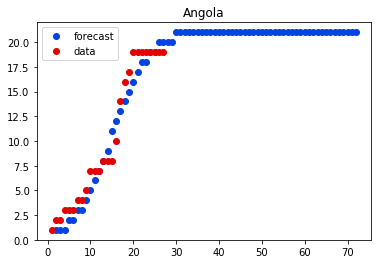

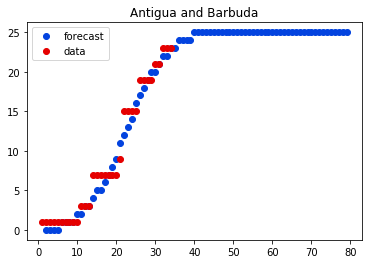

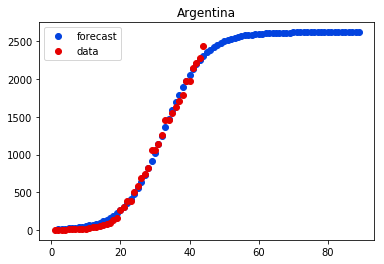

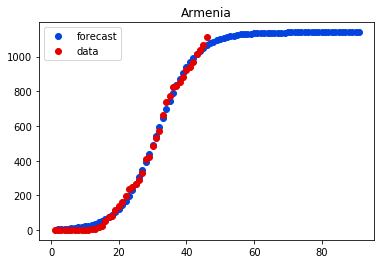

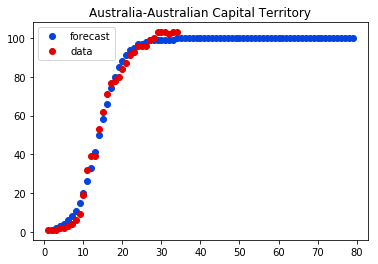

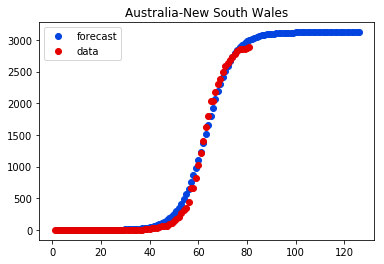

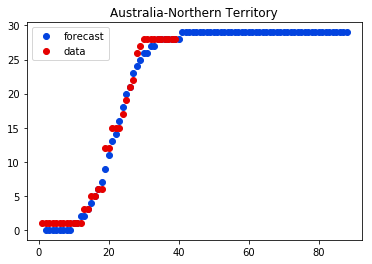

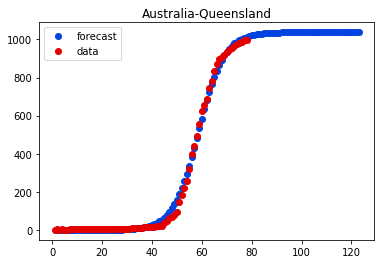

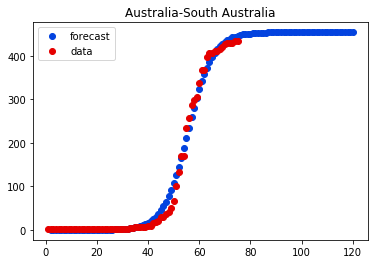

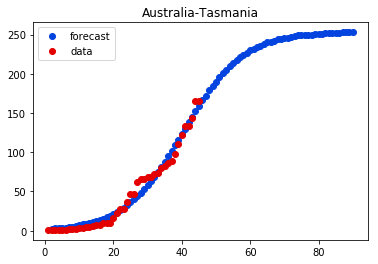

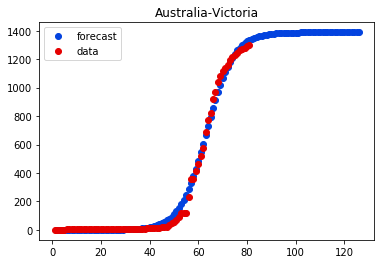

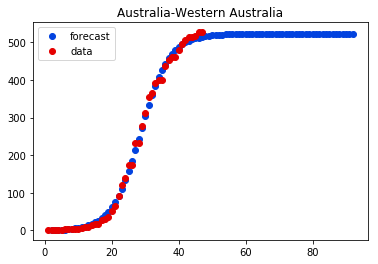

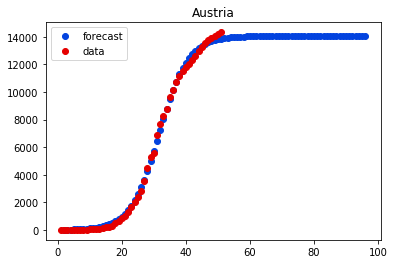

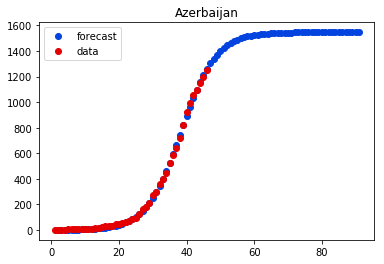

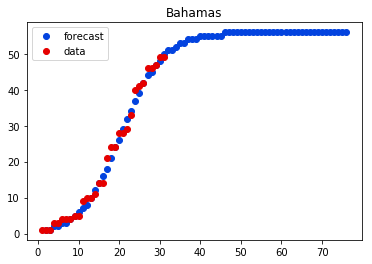

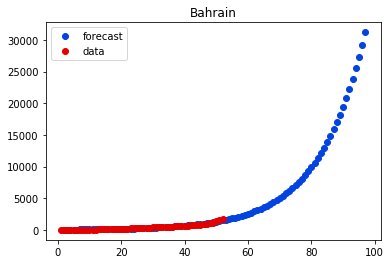

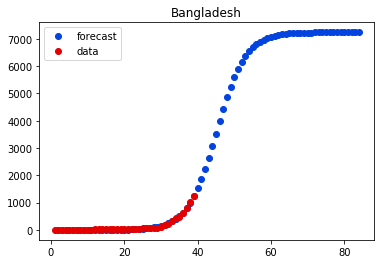

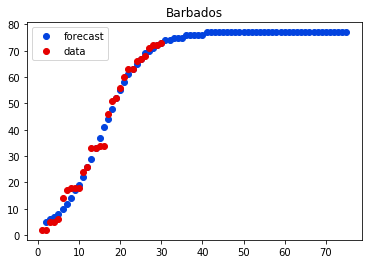

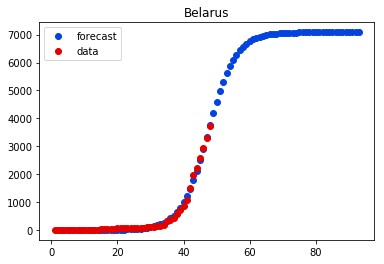

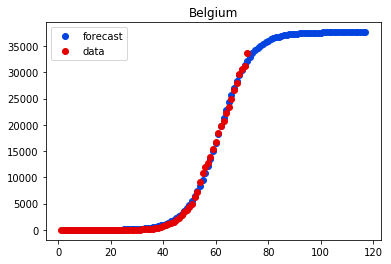

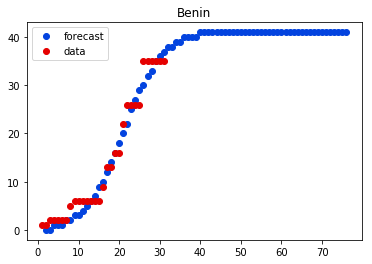

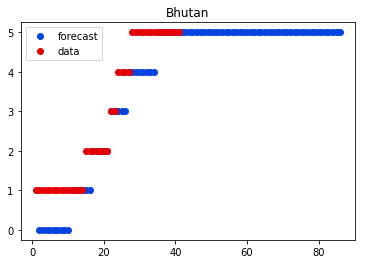

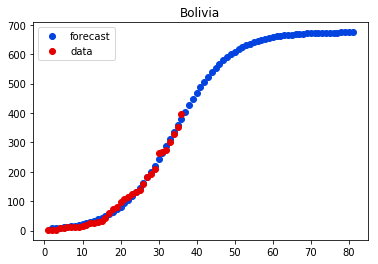

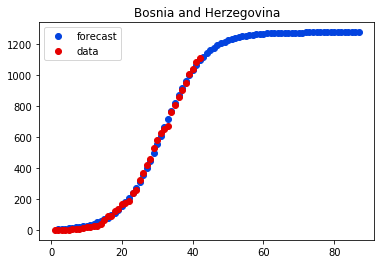

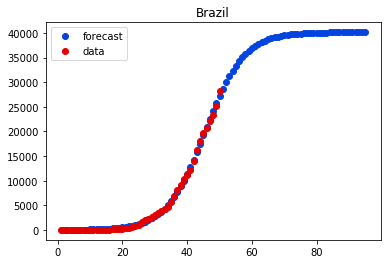

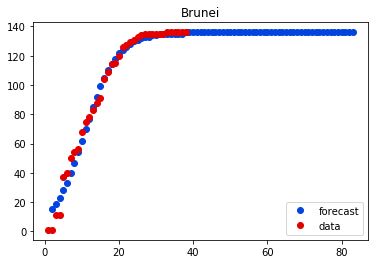

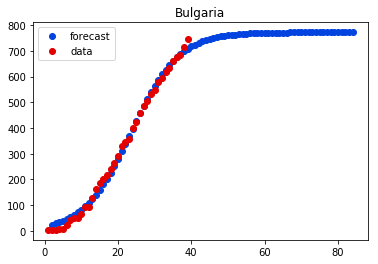

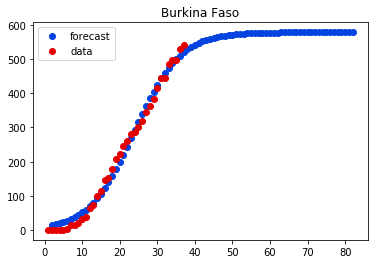

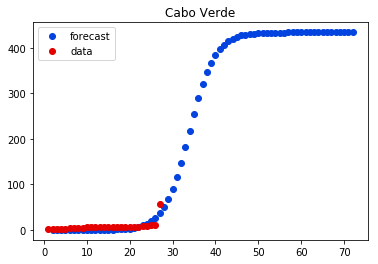

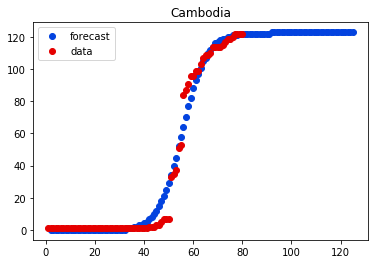

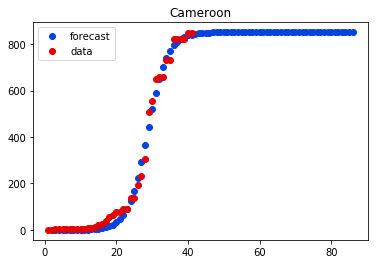

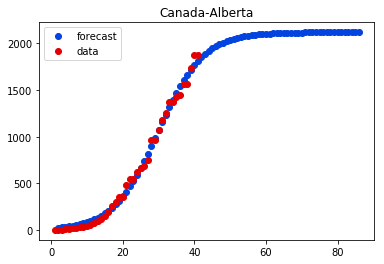

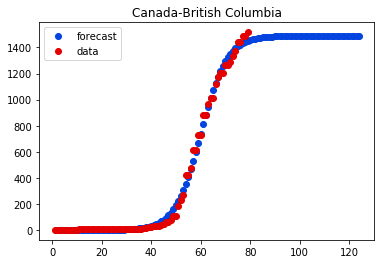

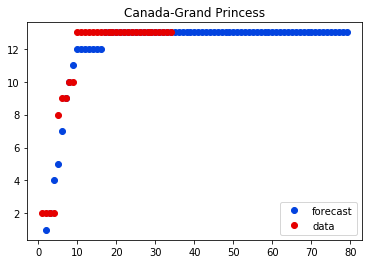

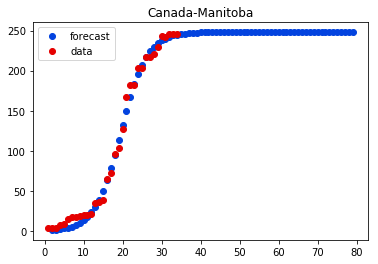

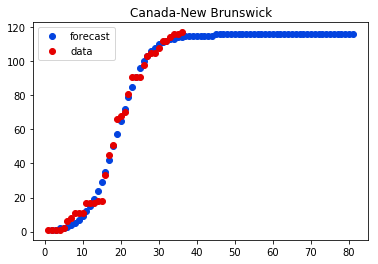

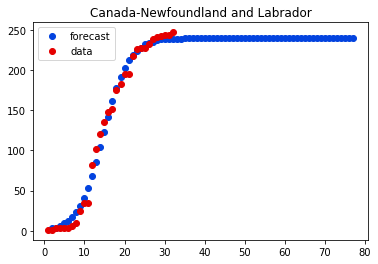

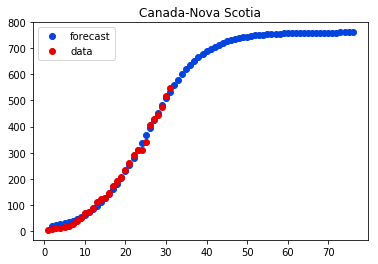

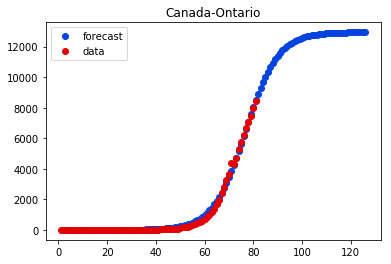

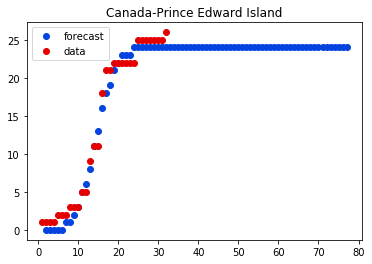

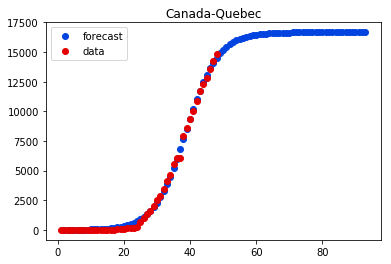

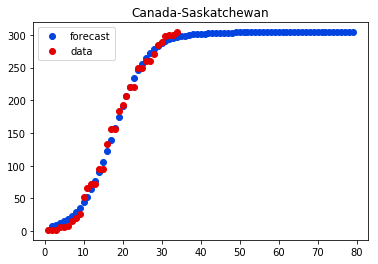

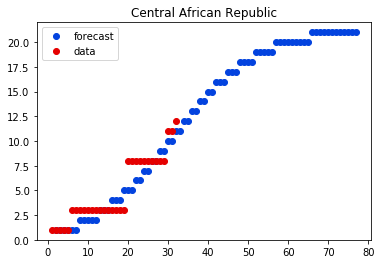

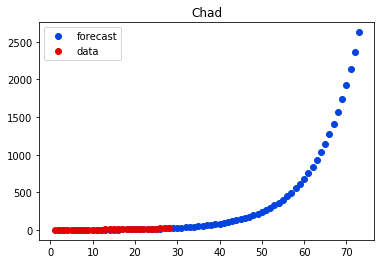

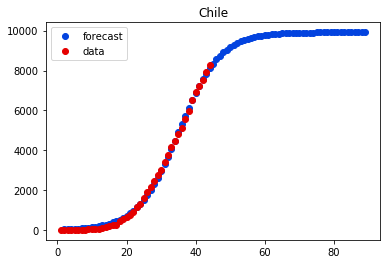

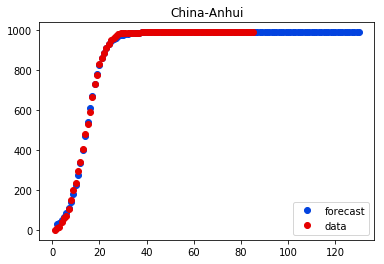

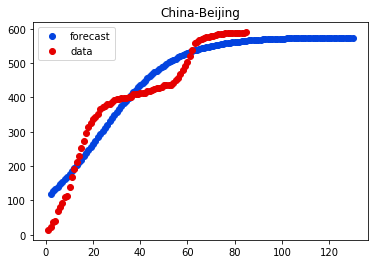

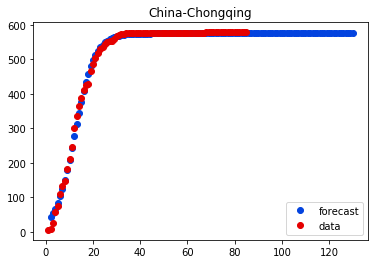

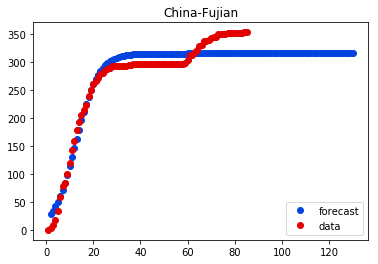

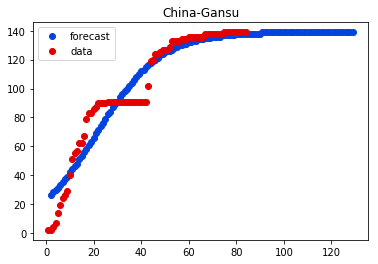

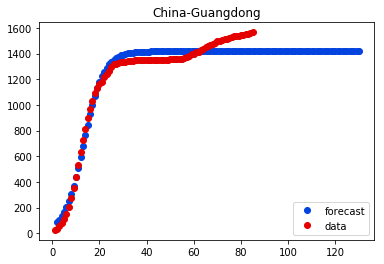

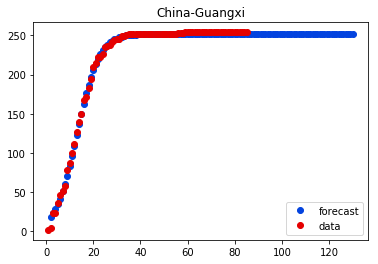

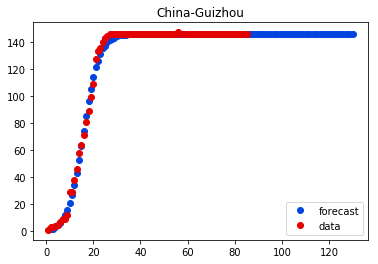

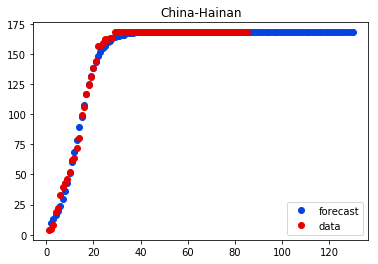

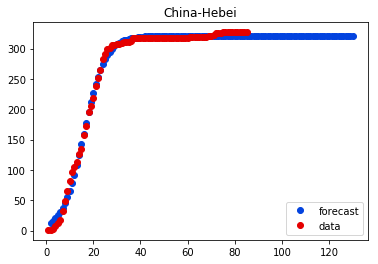

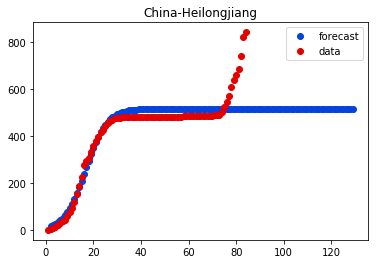

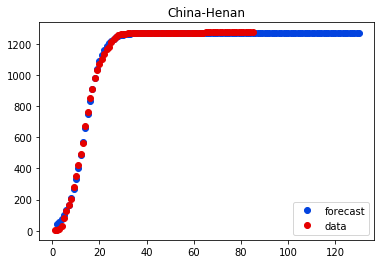

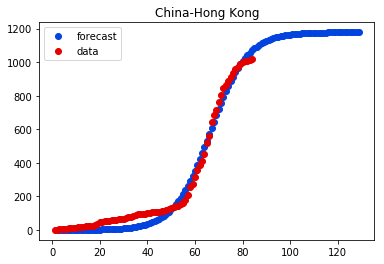

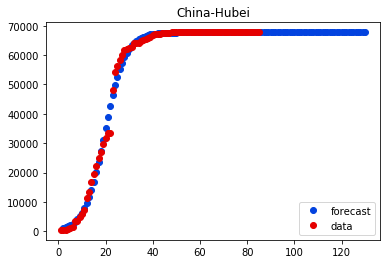

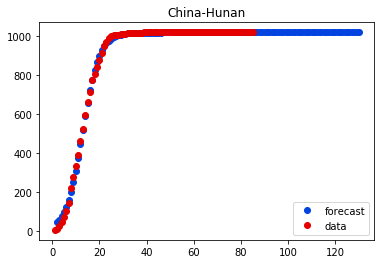

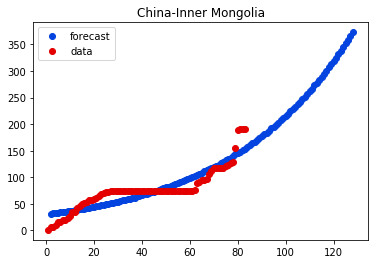

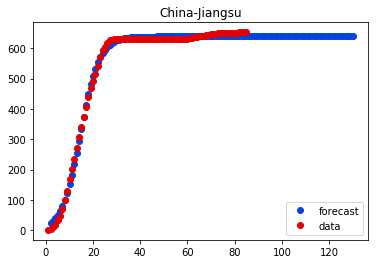

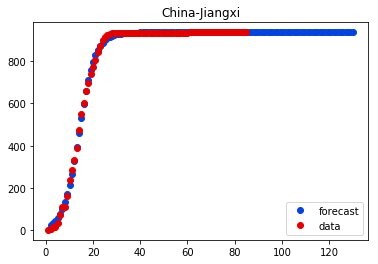

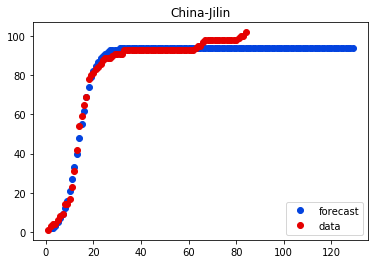

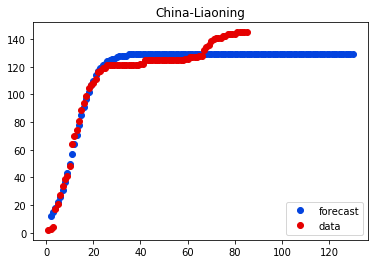

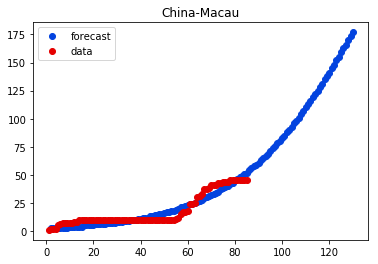

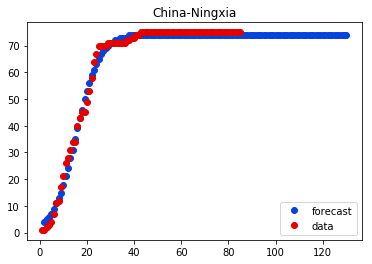

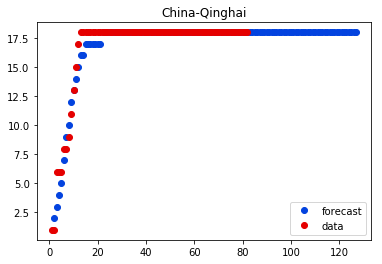

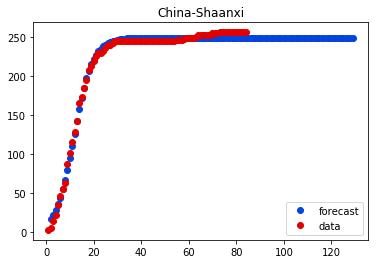

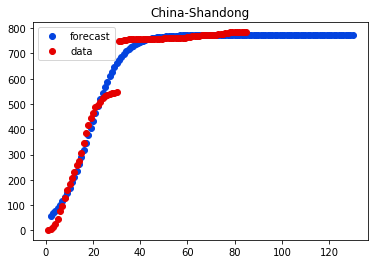

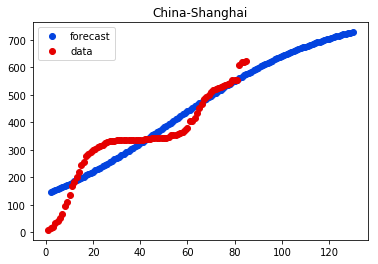

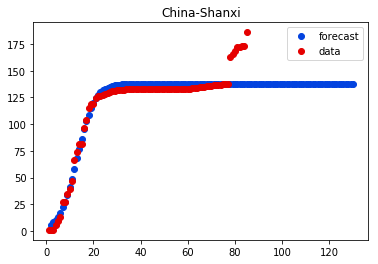

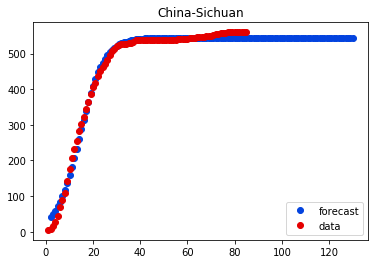

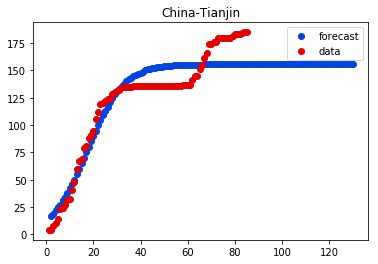

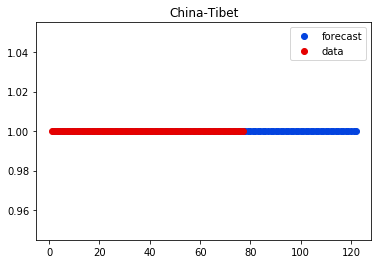

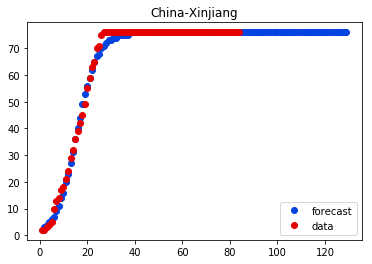

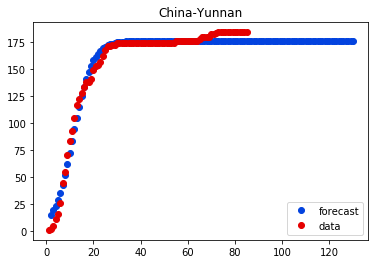

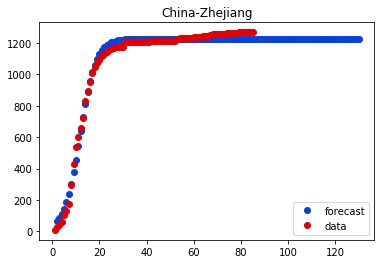

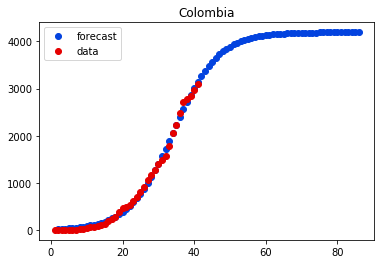

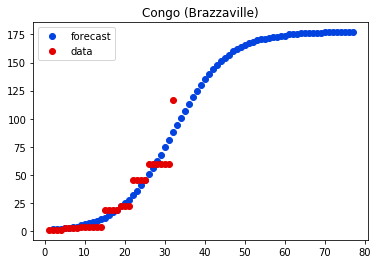

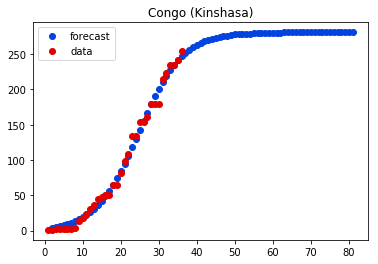

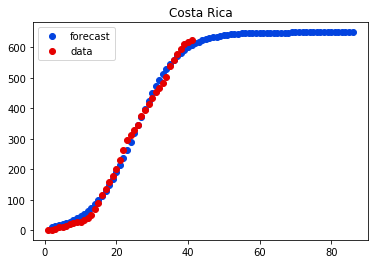

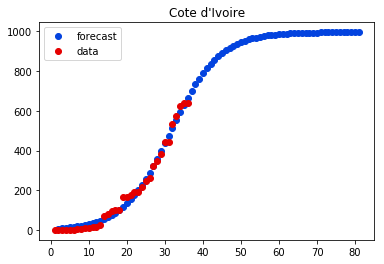

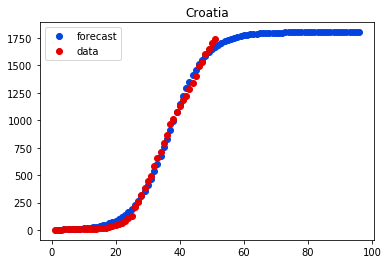

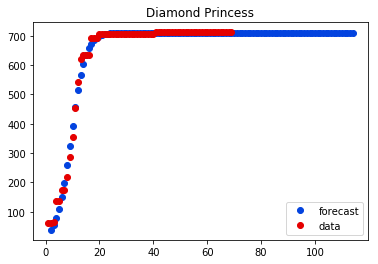

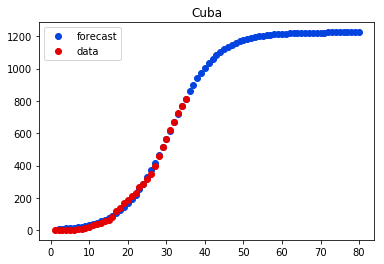

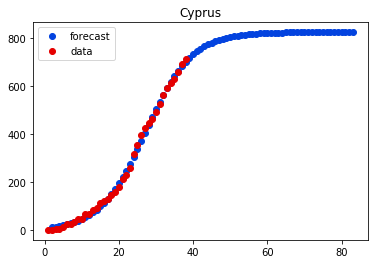

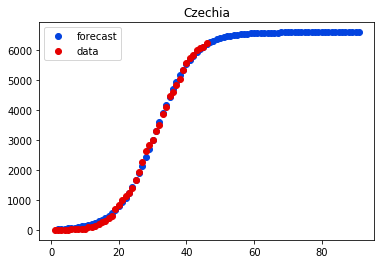

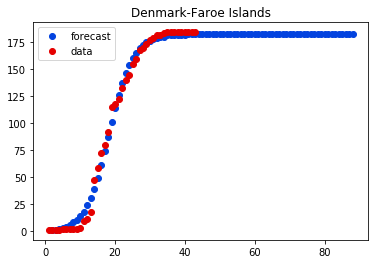

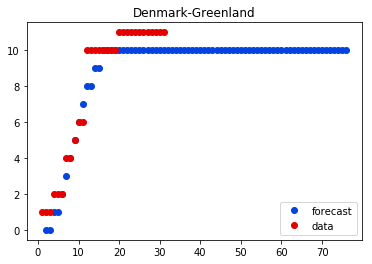

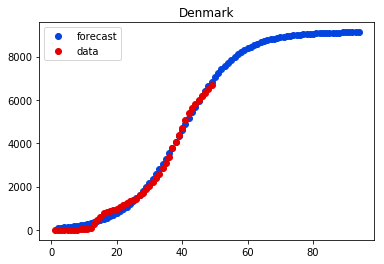

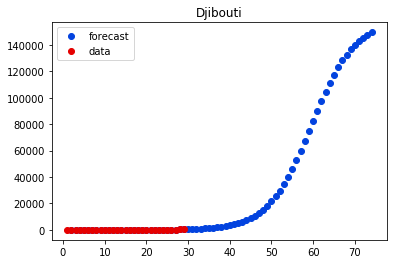

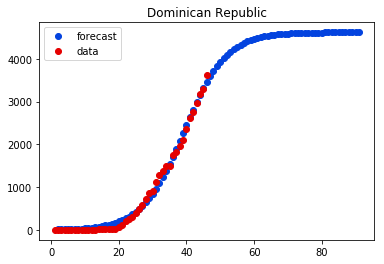

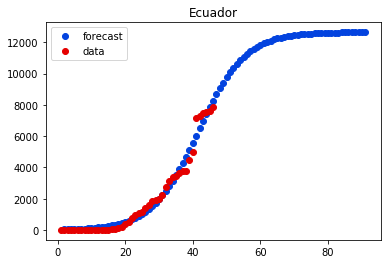

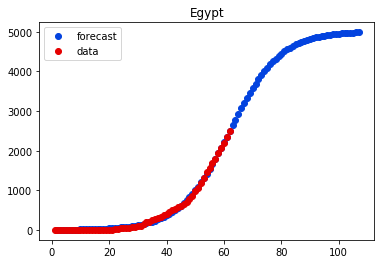

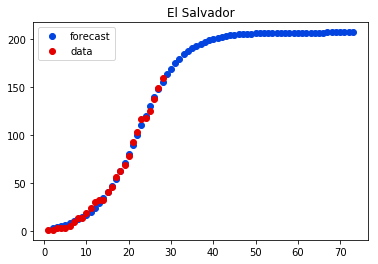

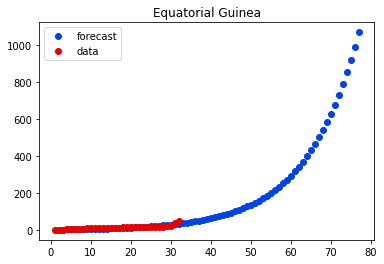

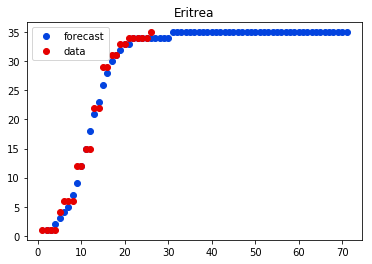

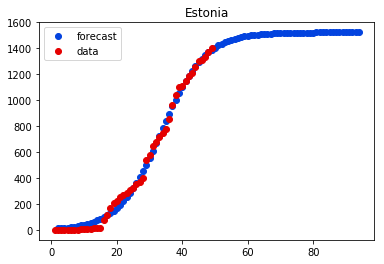

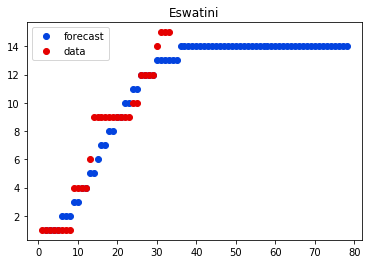

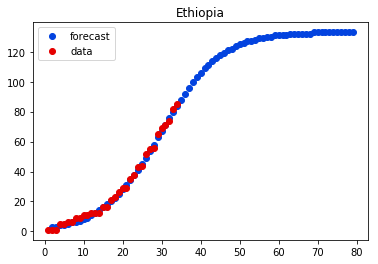

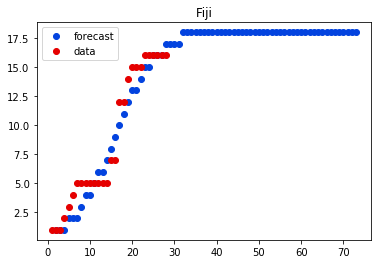

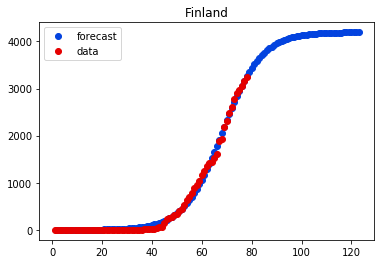

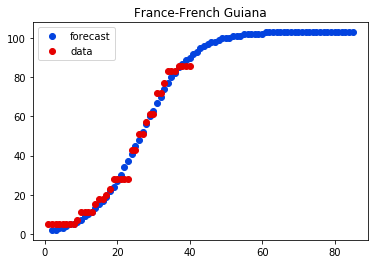

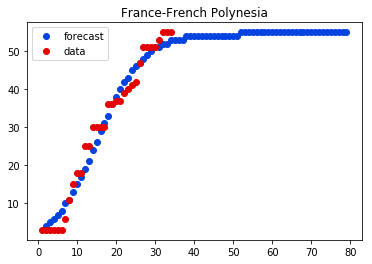

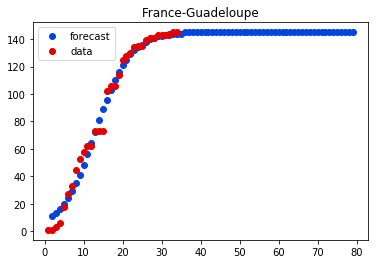

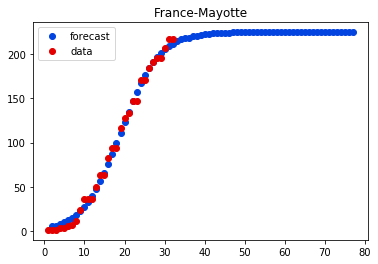

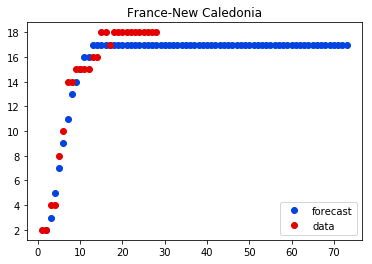

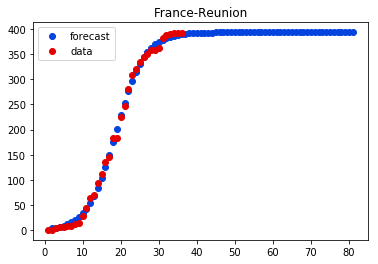

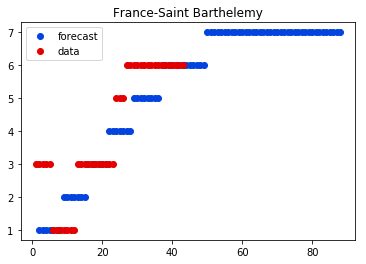

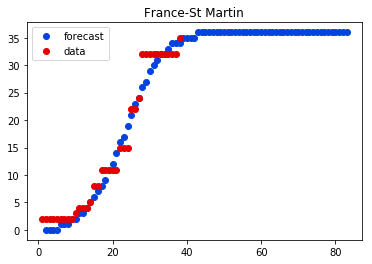

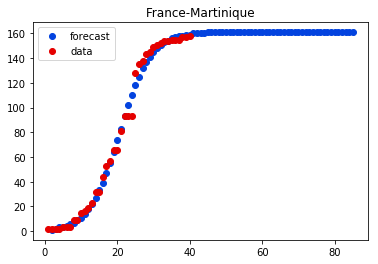

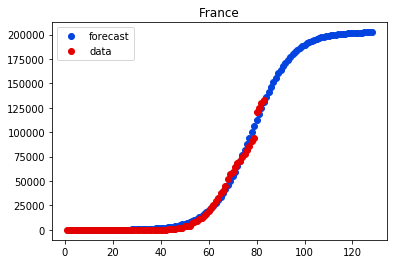

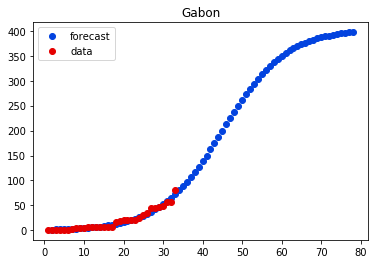

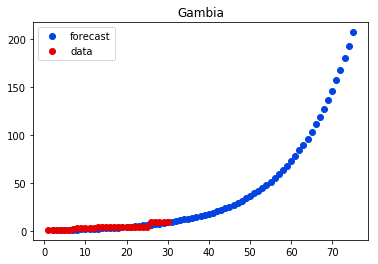

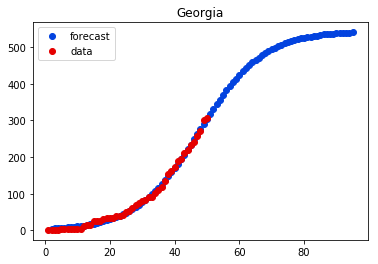

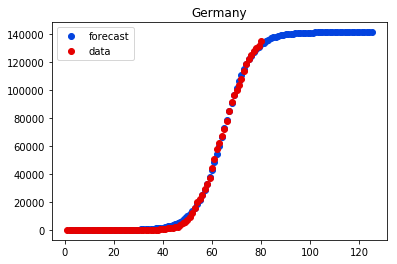

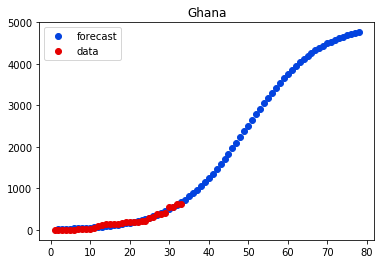

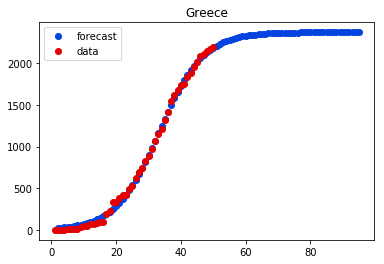

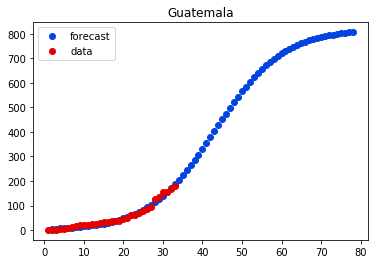

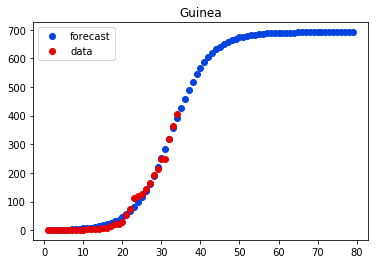

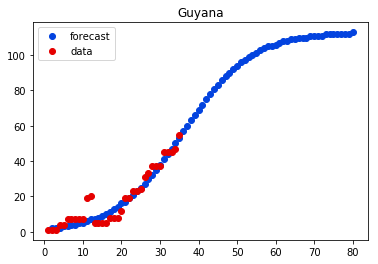

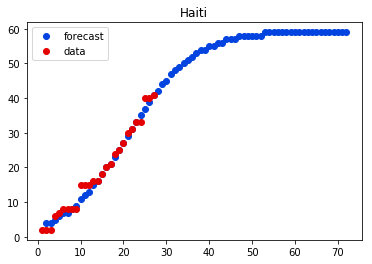

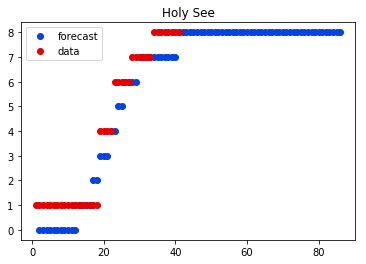

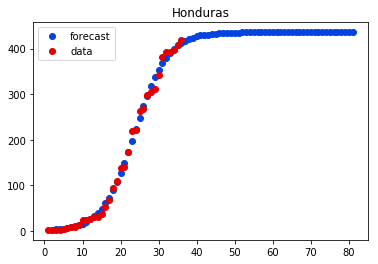

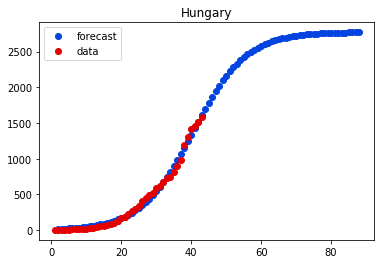

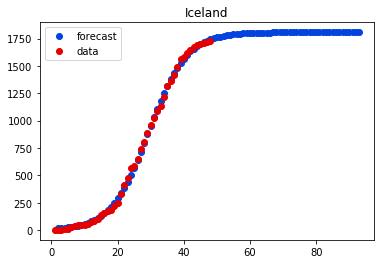

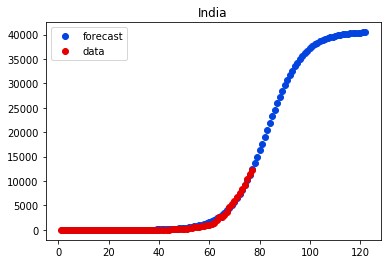

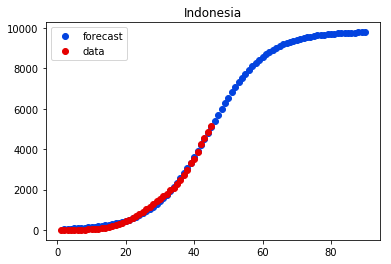

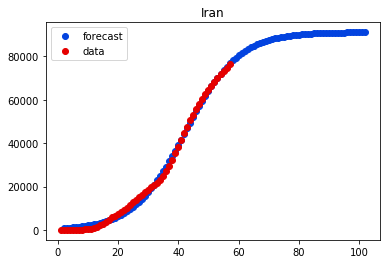

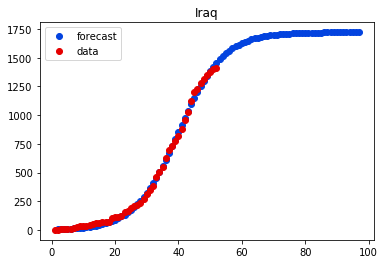

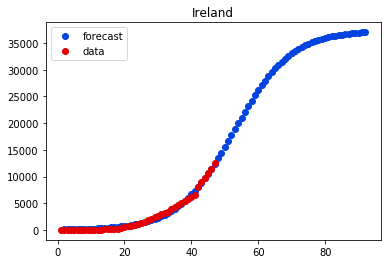

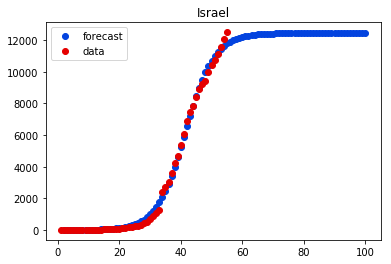

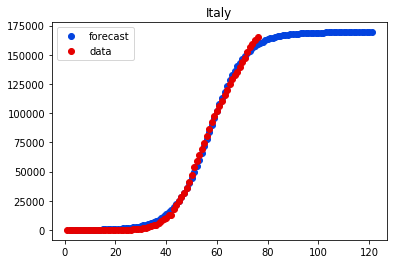

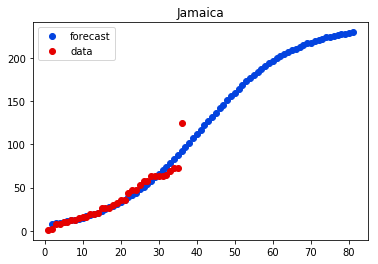

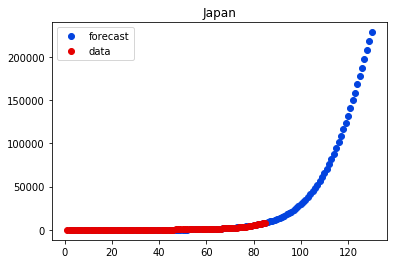

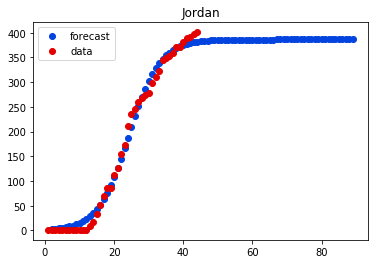

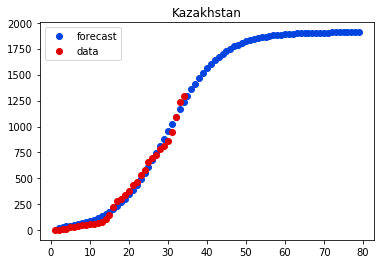

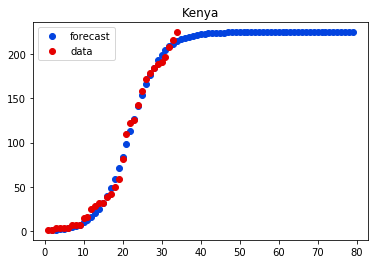

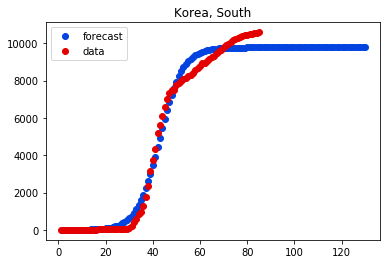

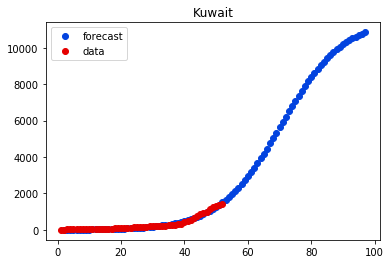

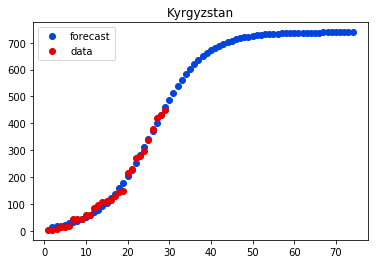

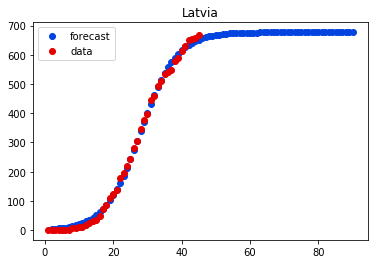

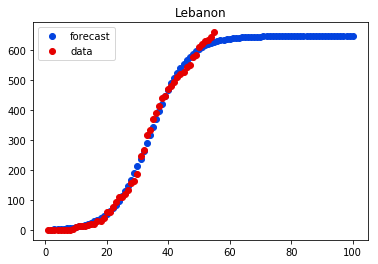

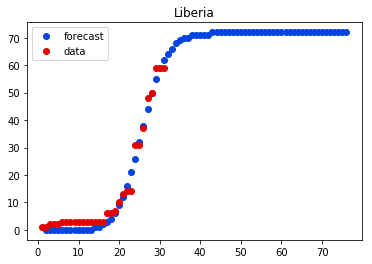

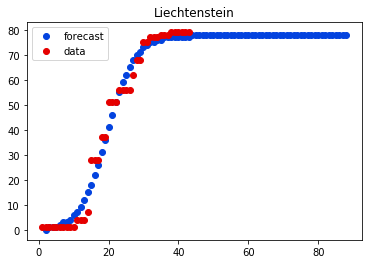

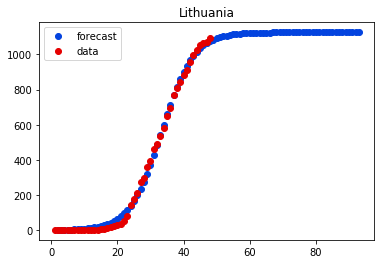

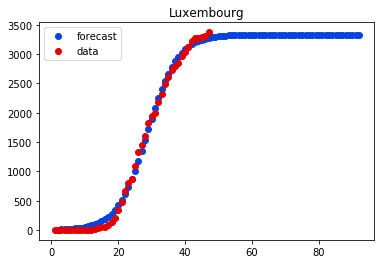

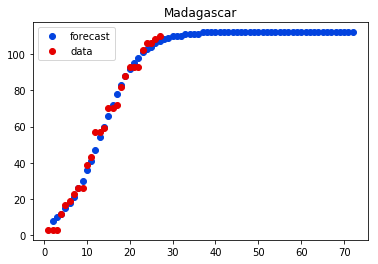

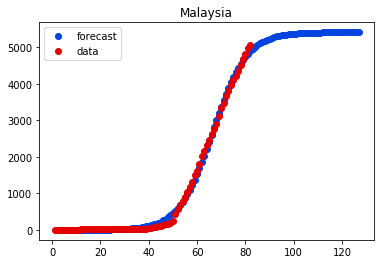

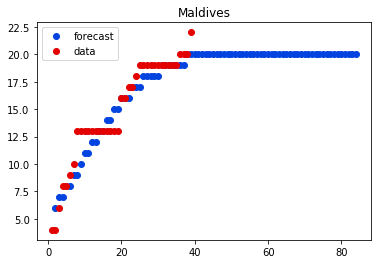

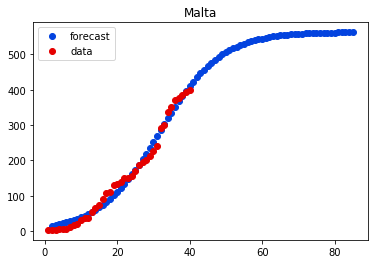

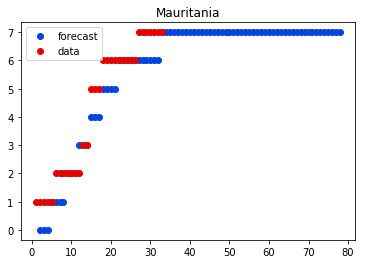

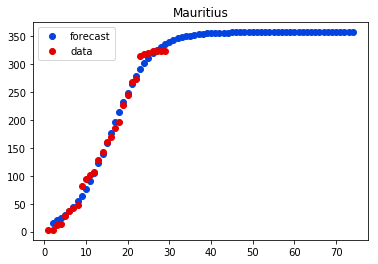

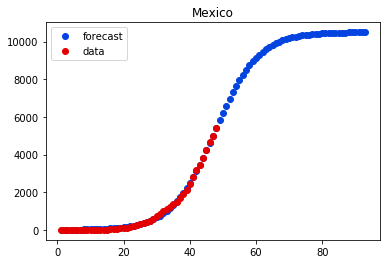

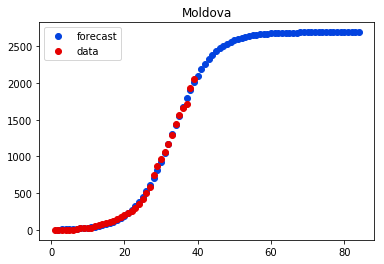

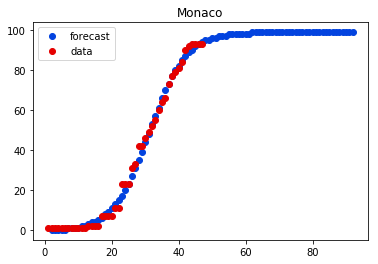

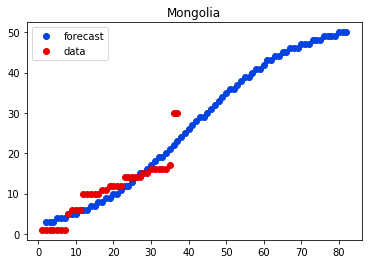

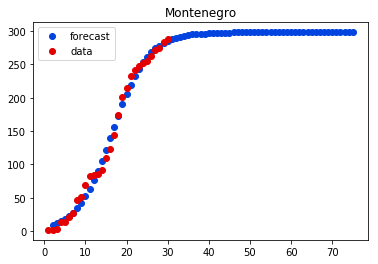

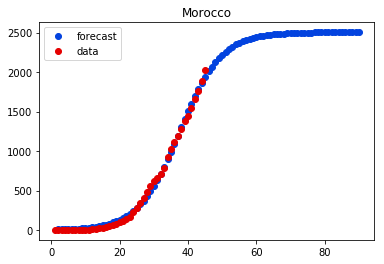

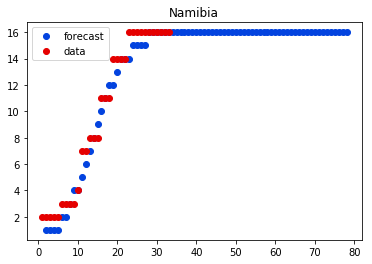

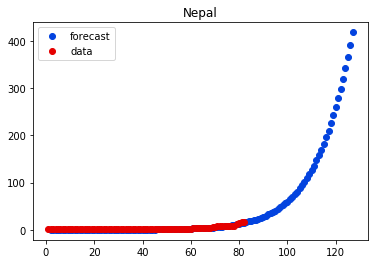

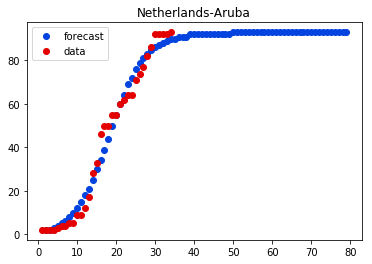

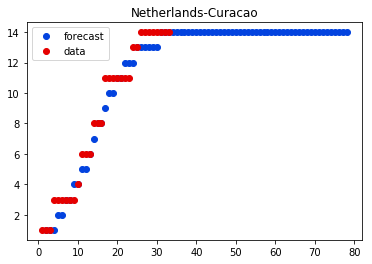

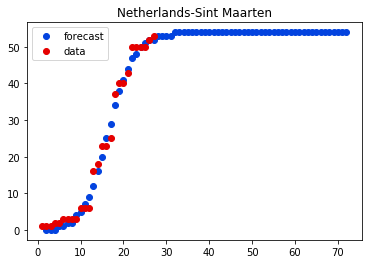

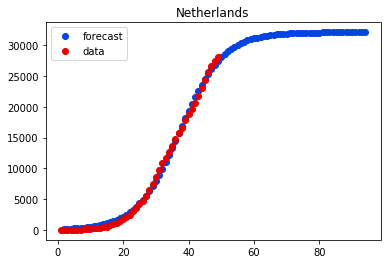

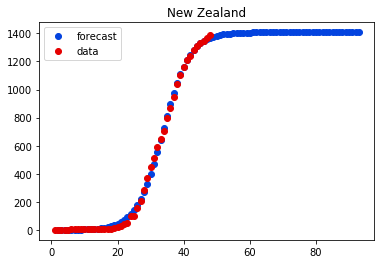

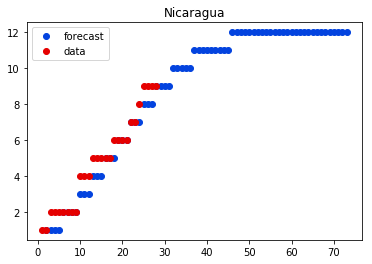

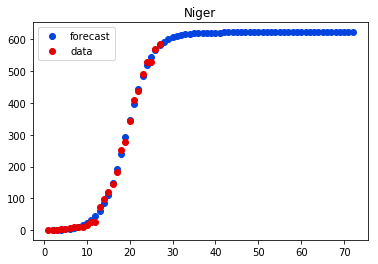

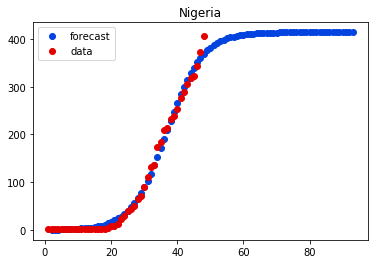

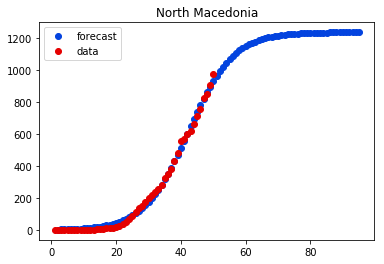

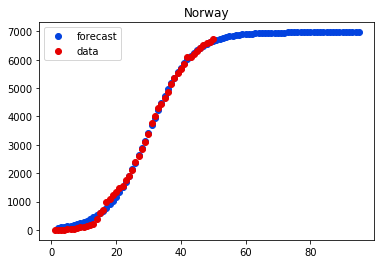

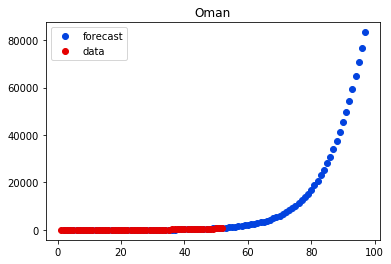

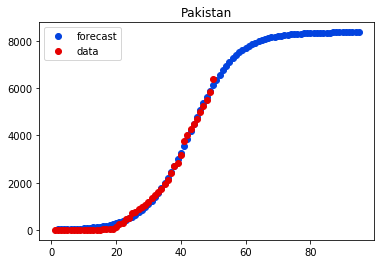

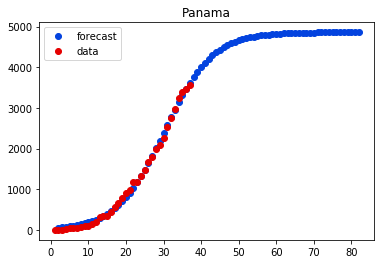

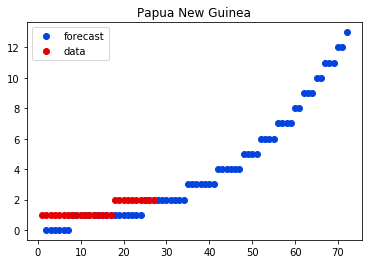

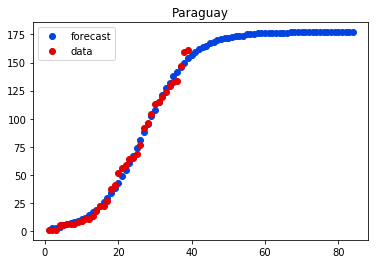

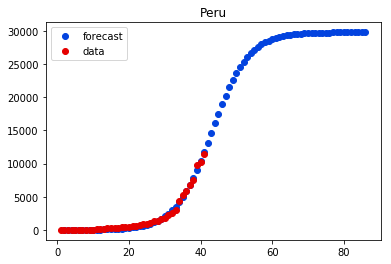

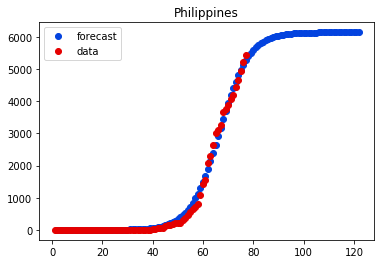

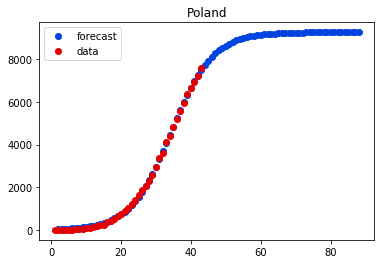

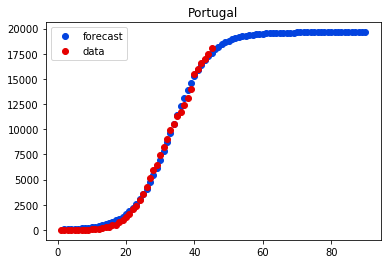

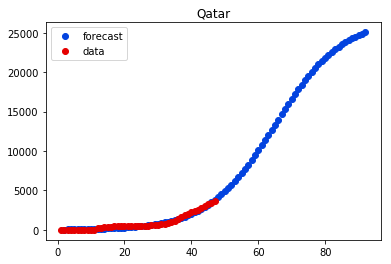

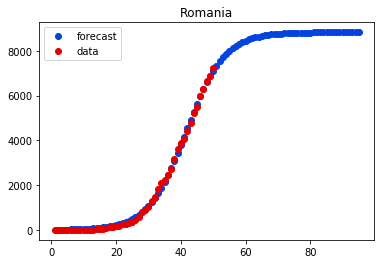

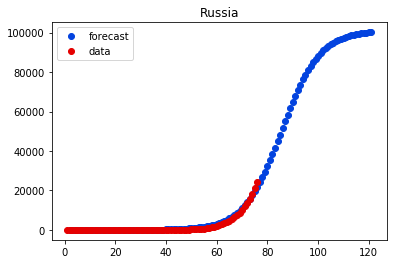

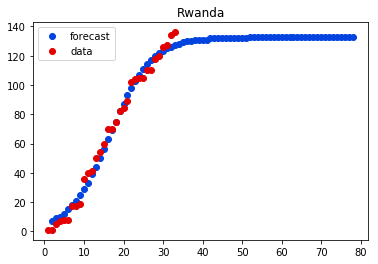

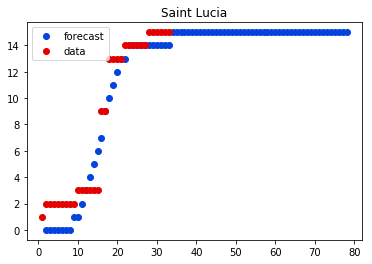

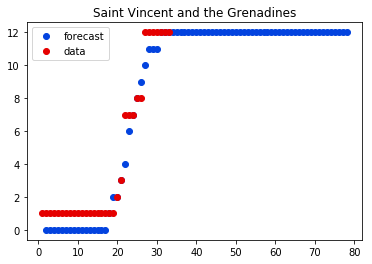

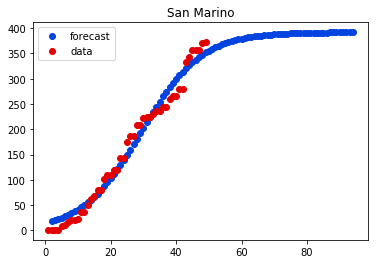

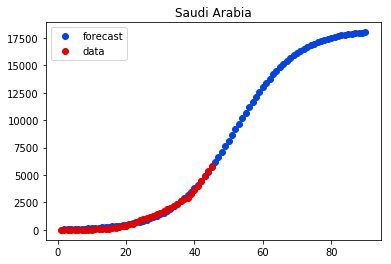

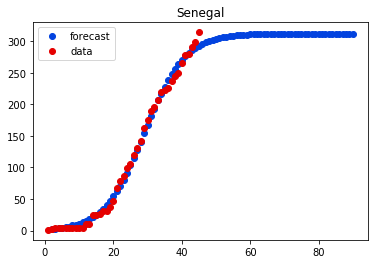

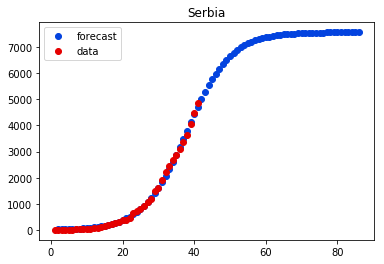

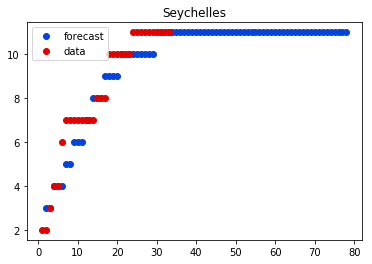

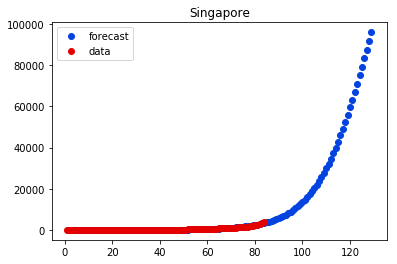

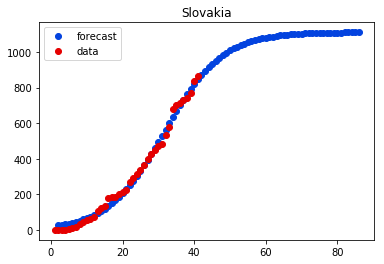

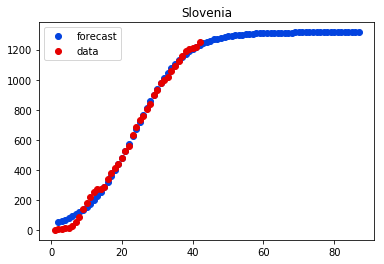

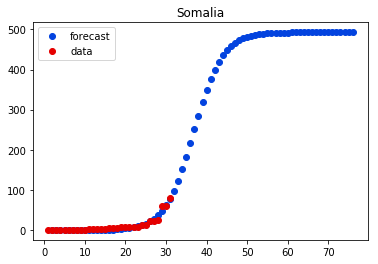

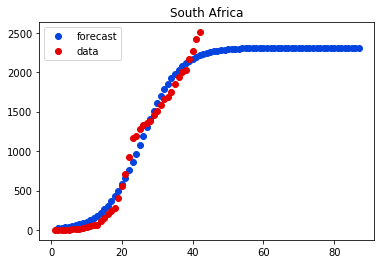

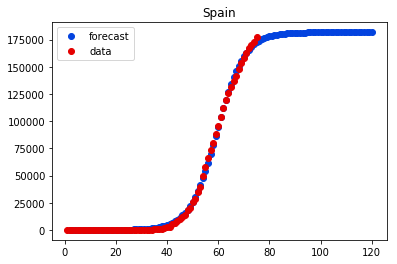

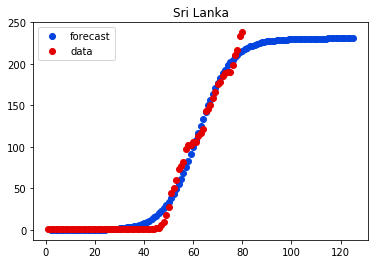

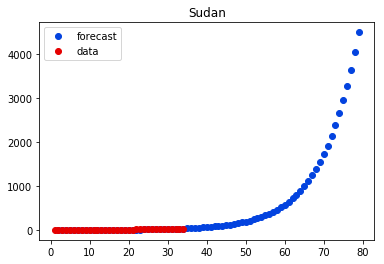

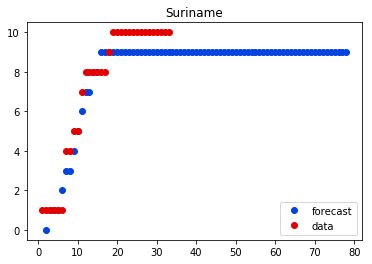

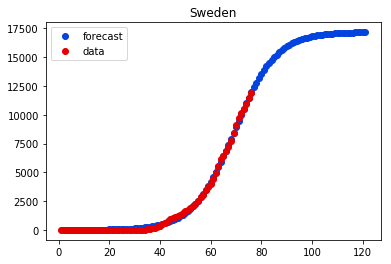

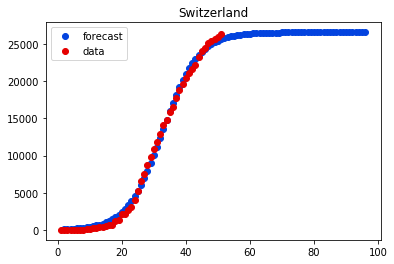

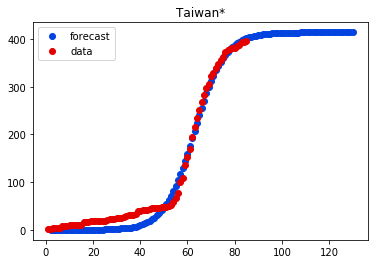

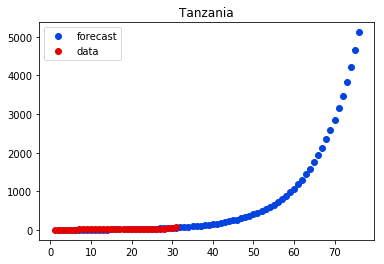

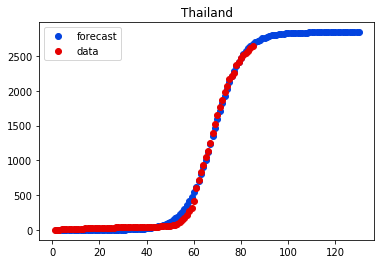

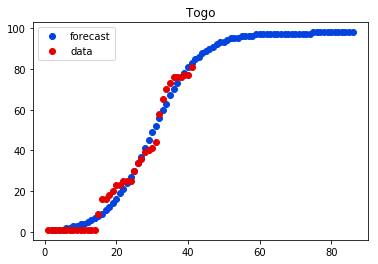

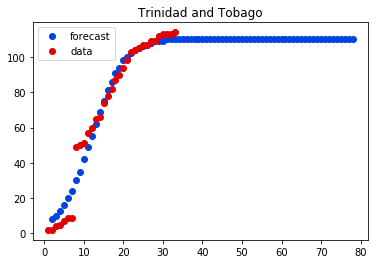

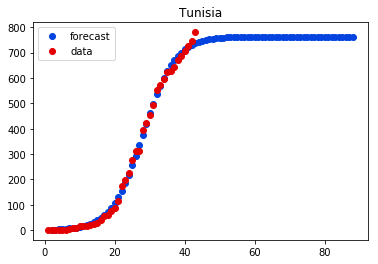

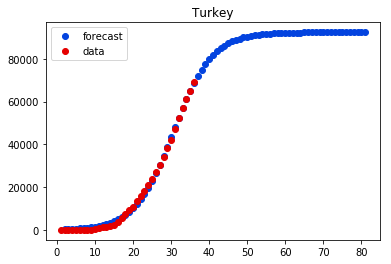

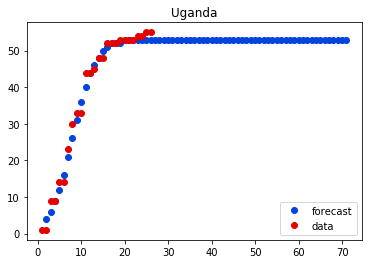

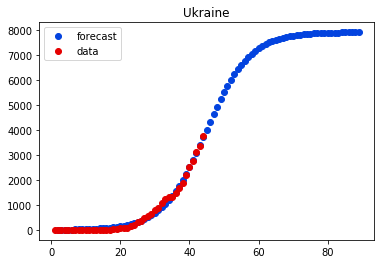

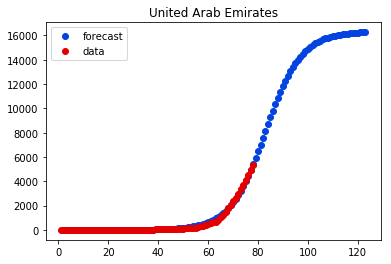

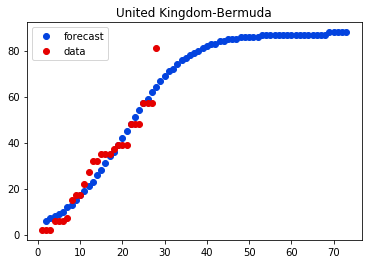

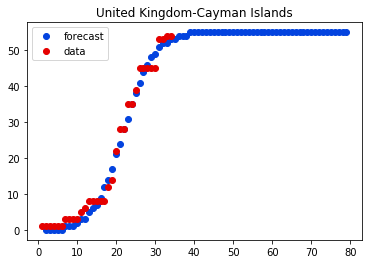

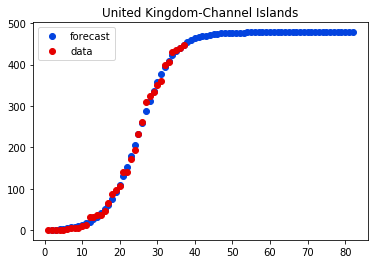

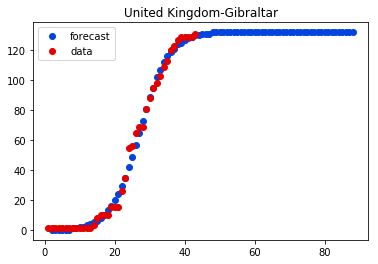

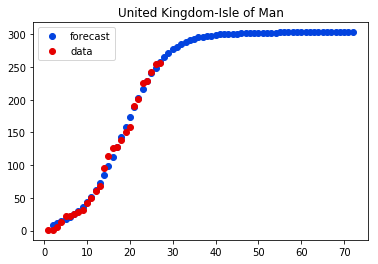

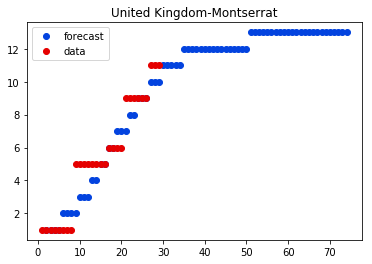

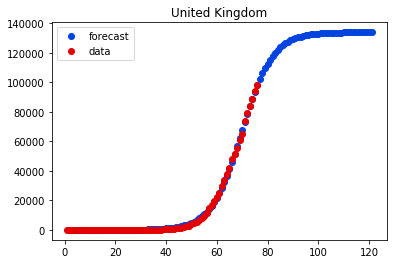

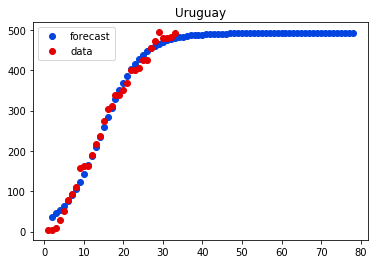

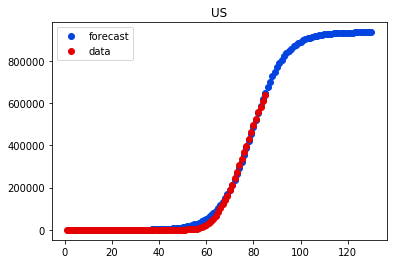

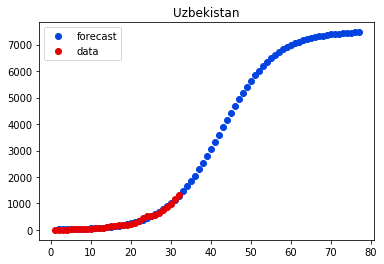

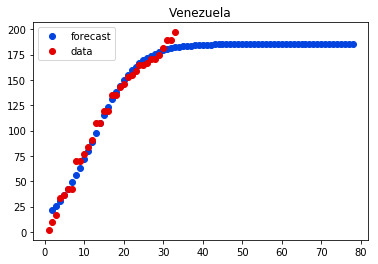

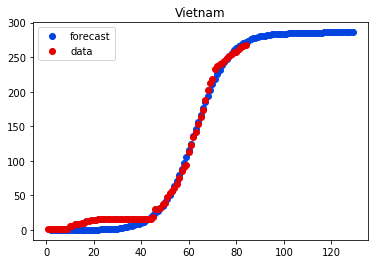

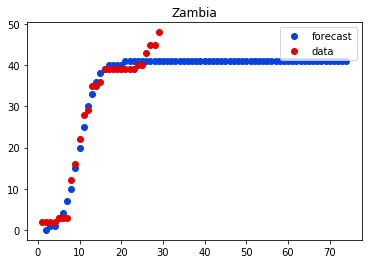

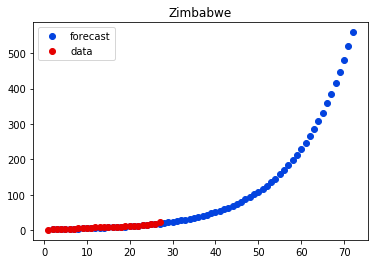

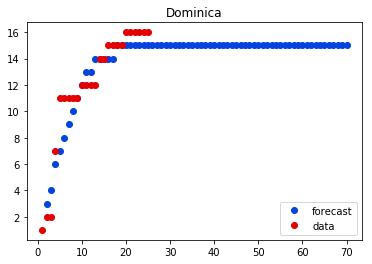

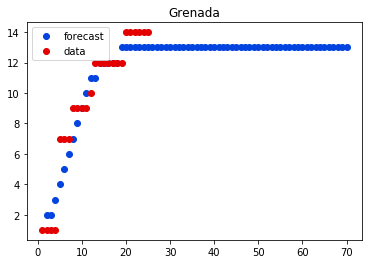

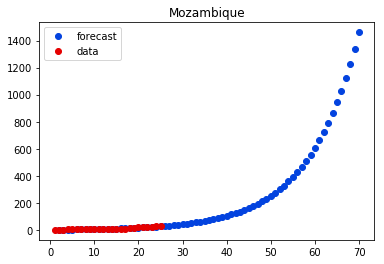

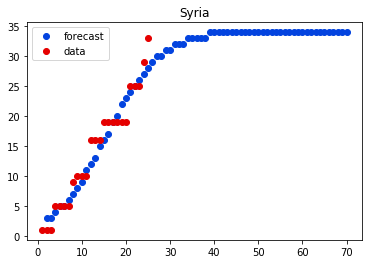

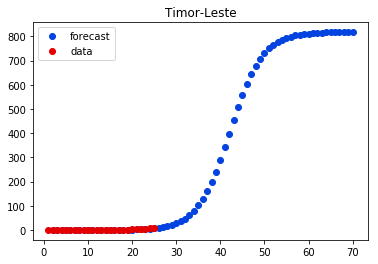

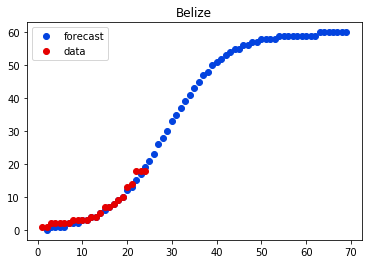

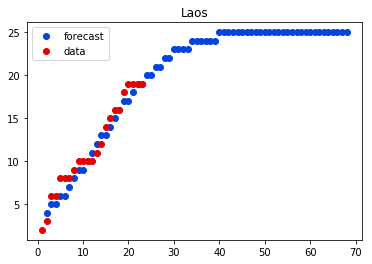

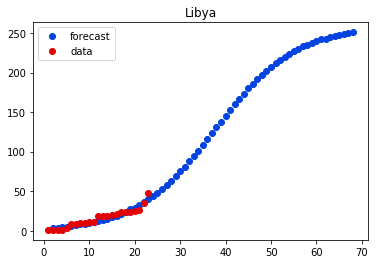

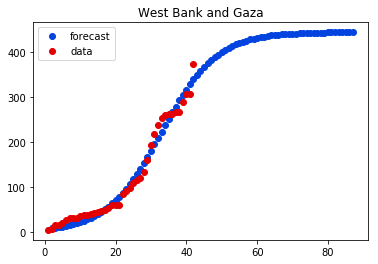

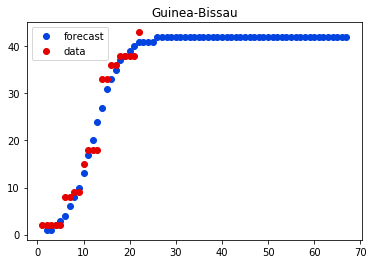

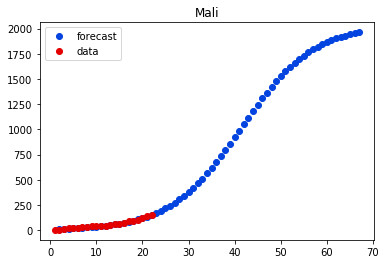

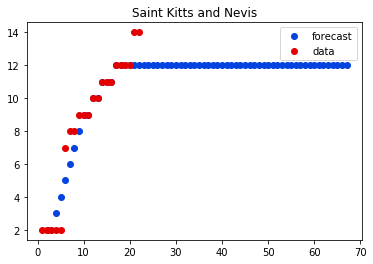

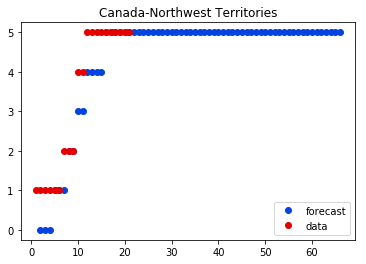

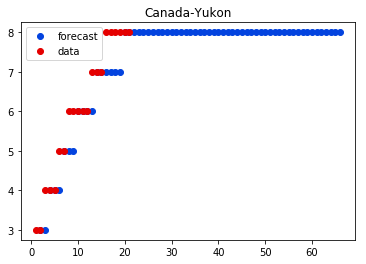

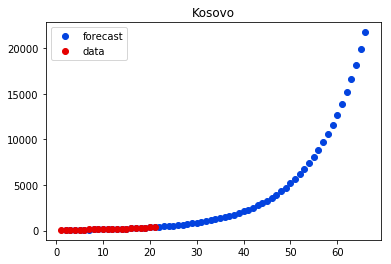

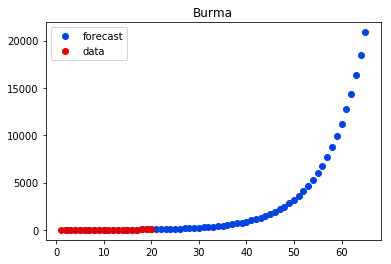

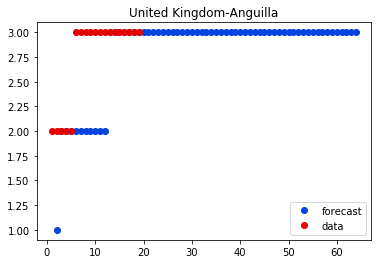

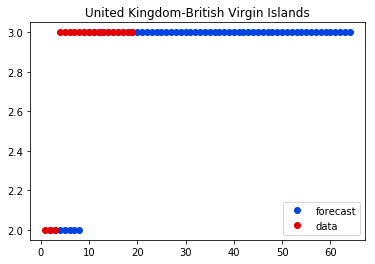

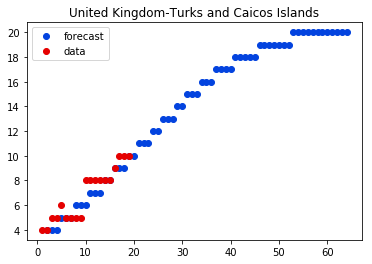

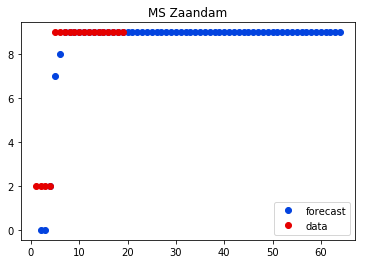

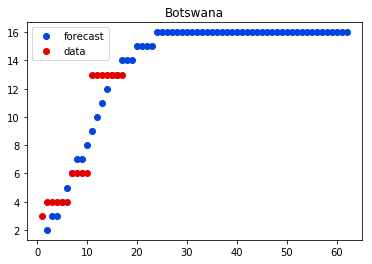

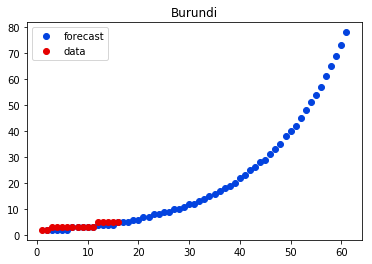

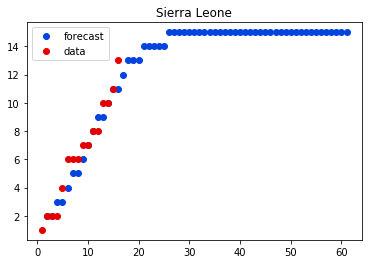

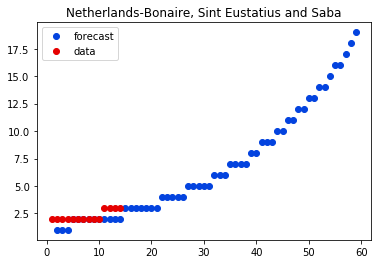

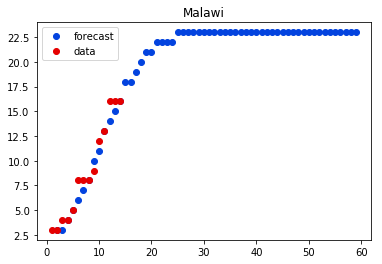

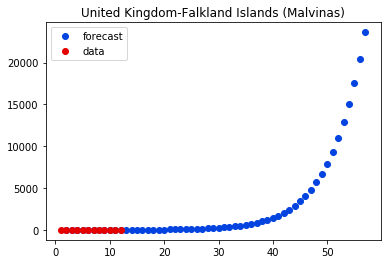

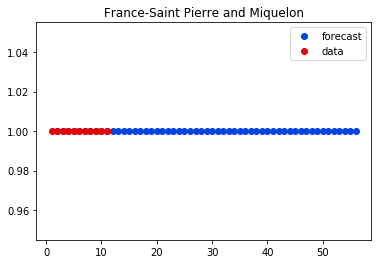

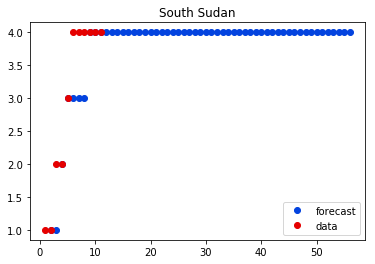

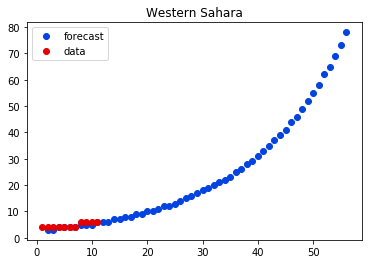

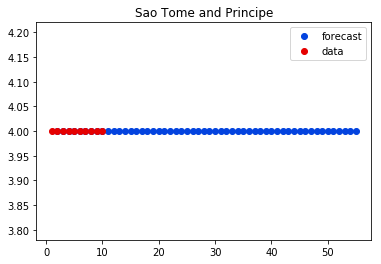

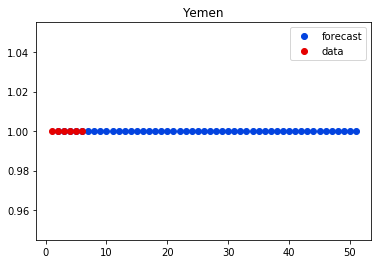

In [30]:
for s in sites[:]:
    test=Final3[Final3['site']==s]
    x,y=np.array(test.days[test['type']=='data']),np.array(test.accumulated[test['type']=='data'])
    xf,yf=np.array(test.days[test['type']=='forecast']),np.array(test.accumulated[test['type']=='forecast'])
    puntosf = plt.plot(xf, yf, 'o', color='xkcd:blue', label = "forecast")
    puntos = plt.plot(x, y, 'o', color='xkcd:red', label = "data")
    plt.legend()
    plt.title(s)
    plt.show()
    print("""
    
    
    """)

In [29]:
test=Final3[Final3['site']==sites[0]]
test.days[test['type']=='forecast']

52      1
53      2
54      3
55      4
56      5
       ..
144    93
145    94
146    95
147    96
148    97
Name: days, Length: 97, dtype: int64

In [17]:
df0[df0['site']=='Canada-Recovered']

,Country/Region,Province/State,site,Lat,Long,date,accumulated
4250,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-01-22,0
4251,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-01-23,0
4252,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-01-24,0
4253,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-01-25,0
4254,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-01-26,0
...,...,...,...,...,...,...,...
4330,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-04-11,0
4331,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-04-12,0
4332,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-04-13,0
4333,Canada,Recovered,Canada-Recovered,0.0,0.0,2020-04-14,0


In [12]:
create_dataframe_with_forecast(df0,'Colombia')

,site,date,accumulated,days,type,growth
7609,Colombia,2020-03-06,1,1,data,Incrementando
7610,Colombia,2020-03-07,1,2,data,Incrementando
7611,Colombia,2020-03-08,1,3,data,Incrementando
7612,Colombia,2020-03-09,1,4,data,Incrementando
7613,Colombia,2020-03-10,3,5,data,Incrementando
...,...,...,...,...,...,...
0,Colombia,2020-05-26,4194,82,forecast,Incrementando
0,Colombia,2020-05-27,4194,83,forecast,Incrementando
0,Colombia,2020-05-28,4194,84,forecast,Incrementando
0,Colombia,2020-05-29,4194,85,forecast,Incrementando


In [47]:
create_dataframe_with_forecast(df0,'Colombia')[1]

2979

In [49]:
Finaldf3=pd.DataFrame()
for s in sites:
    dfi=create_dataframe_with_forecast(df0,s)
    Finaldf3=pd.concat([Finaldf3, dfi])
Final3=Finaldf3.reset_index().drop(columns='index')
fivehours=datetime.timedelta(hours=5)
Final3['date']=Final3['date']+fivehours

In [38]:
scores.values()

dict_values([0.9968530062360847, 0.9973729687859179, 0.9982837612715464, 0.994934554699411, 0.9652231403492361, 0.9771281580341051, 0.9960175244485981, 0.997231887557192, 0.993076215300882, 0.9944798249482062, 0.9911242109587141, 0.99716212851594, 0.993645527740164, 0.9795069164733883, 0.995307379881802, 0.9978267144259128, 0.9984815232610469, 0.9991505079922249, 0.9933539493905111, 0.9793012074763191, 0.9951577255287996, 0.9906081370063999, 0.9961799816390676, 0.998392809050353, 0.9787591124718188, 0.944934086608653, 0.9943612678976479, 0.9983008869526138, 0.9984622006070053, 0.9859740939246006, 0.9953886375009483, 0.9906389200901387, 0.5333442623536384, 0.9847195178051176, 0.9926700166614865, 0.9945959931265165, 0.9965162588400299, 0.9629781715122936, 0.9947061571782828, 0.9936546218779442, 0.9916576069617761, 0.9952629380225247, 0.9967694283432236, 0.9848749585597373, 0.9980983802048311, 0.9946837718161655, 0.8899671825263895, 0.9400453270133836, 0.998363150045317, 0.999485136967291

In [56]:
# CSVout3='forecast_{}_with_hill.csv'.format(str(datetime.date.today()))
# Final3.to_csv(CSVout3)

# properties = {
#     'title': 'COVID-19_FORECAST_hill',
#     'tags': ['COVID-19'],
#     'type': 'CSV'
# }
# csv = gis.content.add(properties, data=CSVout3,folder="covid-19")
# #Se publica para volverlo un dato geográfico
# layer = csv.publish()
# layer

<Item title:"COVID-19_FORECAST_hill" type:Feature Layer Collection owner:rmartin_esri_colombia>